# 导入上一次实现的Seq2Seq模块

In [286]:
import matplotlib.pyplot as plt
import numpy as np
from torch.nn import functional as functional
from torch import Tensor
import pandas as pd
import torch
from torch import nn
from model import seq2seq
import seaborn as sns

# 定义注意可视化函数
使用seaborn封装好的api即可

In [9]:
# 构造10*10的对角矩阵
attention_weight = torch.eye(10)
attention_weight

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

解释一下这个图的含义
x轴:keys(可认为是待预测向量x_predict)
y轴:queries(可认为是先验知识中的x_train)
其中[xi][yj]表示xi与yi的相关性

Text(33.0, 0.5, 'queries')

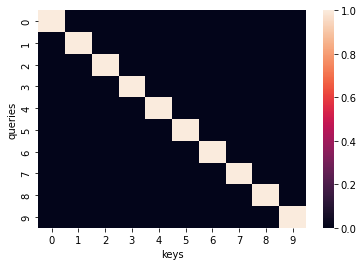

In [12]:
sns.heatmap(attention_weight)
plt.xlabel('keys')
plt.ylabel('queries')

# 注意力汇聚
几种不同的注意力机制的演示

构造训练集

In [14]:
def f(x):
    return 2*torch.sin(x)+torch.pow(x,0.8)

In [21]:
n_train = 50
x_train,_ = torch.sort(torch.rand(n_train)*5)
# 添加高斯噪音 指定形状
y_train = f(x_train) + torch.normal(0.0,0.5,(n_train,))

构造测试集

In [22]:
x_test = torch.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数

定义一个绘图函数

In [75]:
def plot_kernel_reg(y_hat):
    plt.plot(x_test,y_truth)
    plt.scatter(x_test,y_train,alpha=0.5,color='red')
    plt.plot(x_test,y_hat,'--')
    plt.legend(['truth','train','predict'])

最简单粗暴的注意力汇聚-取均值

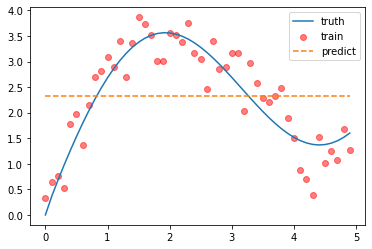

In [76]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

# 非参注意力汇聚(核函数定义为a(x,xi))

$$f(x) = \sum_{i=1}^{n}{a(x,xi)yi}$$

其中x是已有先验知识的集合
$a(x,xi)$ 表示当前输入x(key)与先验知识xi的相似度
$a(x,xi)yi$表示当前xi对应的标签yi加权后的结果
注意力机制的本质就是 加权平均

将输入x(query)重复n_train遍:这一步为了方便计算$\sum_{i=1}^{n}{a(x,xi)yi}$
利用矩阵计算一次性就算完了所有xi与x的相似度

In [81]:
x_repeat = x_test.repeat_interleave(n_train).reshape((-1, n_train))
x_repeat.shape

torch.Size([50, 50])

定义批量相似度计算函数

In [85]:
def a(queries_repeat,keys):
    return -torch.pow((queries_repeat - keys),2)/ 2

批量计算相似度(先计算相似度,再softmax概率归一化)

In [88]:
attention_weights = functional.softmax(a(x_repeat,x_train), dim=1)

批量计算加权yi(value)
做矩阵内积(每一行(向量)a[i]都乘以(标量)y[i]进行加权)

In [89]:
y_hat = torch.matmul(attention_weights,y_train)

观察一下使用非参注意力(相似度计算函数为a)下的汇聚结果

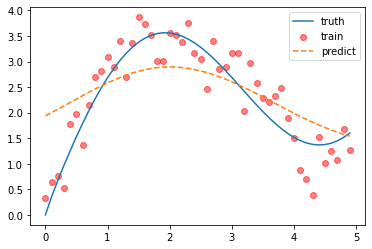

In [92]:
plot_kernel_reg(y_hat)

观察注意力分布(即key[i] 与queries[i]的相似程度)

<AxesSubplot:>

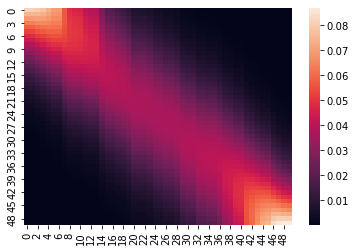

In [93]:
sns.heatmap(attention_weights)

# 带参的注意力汇聚
$$f(x) = \sum_{i=1}^{n}{a(x,xi)yi}$$
$$f(x) = \sum_{i=1}^{n}{softmax(-\frac{1}{2}((x-xi)w)^2)yi}$$

定义带参模型
forward中 self.attention_weights的形状[batch_size,n_train] 代表每一个batch下的query与key的相似度
最后bmm是 [batch_size,1,n_train] * [batch_size,n_train,1] 的mat乘法

In [168]:
class NWKernelRegression(nn.Module):
    def __init__(self,**kwargs):
        super(NWKernelRegression, self).__init__()
        self.weights = nn.Parameter(torch.rand((1,)),requires_grad=True)
    def forward(self,queries:Tensor,keys,values):
        """
        :param queries: [batch_size,n_train] 表示 查询数量,已有先验知识数量
        :param keys: [batch_size,n_train] 先验知识
        :param values: [batch_size,n_train] 先验知识
        :return:
        """
        _n_train = keys.size(1)
        queries = queries.repeat_interleave(_n_train).reshape((-1, _n_train))
        self.attention_weight = self.kernel(queries,keys)
        return torch.bmm(self.attention_weight.unsqueeze(1),values.unsqueeze(-1)).reshape(-1)
    def kernel(self,queries_repeat,keys):
        return nn.functional.softmax(-(((queries_repeat-keys)*self.weights)**2)/2,dim=1)

构造批量的先验知识

In [108]:
batch_x_train = x_train.repeat((n_train, 1))
batch_y_train = y_train.repeat((n_train, 1))

从先验知识中去除自己以构造训练集(自己不能和自己计算注意力)

In [109]:
select_mat = (1 - torch.eye(n_train)).type(torch.bool)
keys = batch_x_train[select_mat].reshape((n_train, -1))
values = batch_y_train[select_mat].reshape((n_train, -1))

尝试着去训练模型

In [169]:
net = NWKernelRegression()
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
loss_dict = {}
for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l_sum = l.sum()
    l_sum.backward()
    loss_item = l_sum.data
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(loss_item):.6f}')
    loss_dict[epoch + 1] = float(loss_item)

epoch 1, loss 40.627140
epoch 2, loss 8.421967
epoch 3, loss 8.413544
epoch 4, loss 8.405094
epoch 5, loss 8.396616


观察损失图

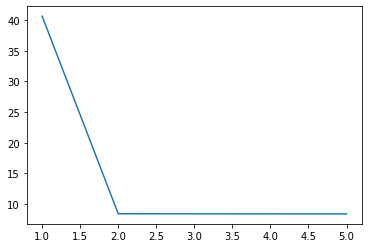

In [170]:
plt.plot(loss_dict.keys(),loss_dict.values())

进行预测

In [ ]:
# 为了批量计算kernel
keys = x_train.repeat((n_test,1))
values = y_train.repeat((n_test,1))

In [158]:
y_hat = net(x_test,keys,values).detach()

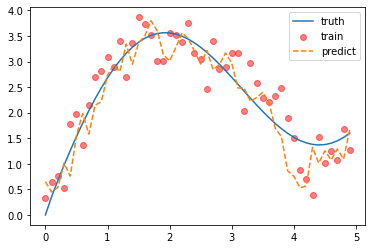

In [171]:
plot_kernel_reg(y_hat)

<AxesSubplot:>

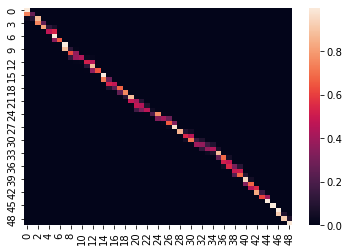

In [165]:
sns.heatmap(net.attention_weight.detach())

![attention](https://zh-v2.d2l.ai/_images/attention-output.svg)

# 使用不同的注意力汇聚函数
# $a(x,xi)$

遮蔽的softmax函数
x的形状[batch_size,seq_len,key_size] 表示batch下每句话的每个位置对每个词的预测分数
valid_lens[batch_size] 用于对每个batch下的句子进行遮蔽
# .....凸(艹皿艹 ) 解释不通了......
这里认为一个单独的值表示一个词,这样就能解释的通

In [279]:
def masked_softmax(x,valid_lens):
    """
    :param x: [batch_size,seq_len,vocab_size]
    [0][0][0]表示第一个批量数据 第一个词 在词汇表中索引为0的预测分数
    :param valid_lens: [batch_size]
    [0]表示第一个batch下有意义的句子长度
    :return:
    """
    shape = x.shape
    if valid_lens is None:
        return x
    elif valid_lens.dim() == 1:
        valid_lens = torch.repeat_interleave(valid_lens, shape[1])
    else:
        valid_lens = valid_lens.reshape(-1)
    # 多个batch合成一个batch [batch*seq_len,vocab_size]
    x = x.reshape(-1,shape[-1])
    x = seq2seq.MaskedSoftmaxCELoss.sequence_mask(x,valid_lens,value=-1e6)
    return nn.functional.softmax(x.reshape(shape),dim=-1)

但是这个函数确实可以遮蔽.....虽然没搞懂为啥遮蔽了vocab_index_prob

In [198]:
_x = torch.rand(2, 2, 4)
_valid_lens = torch.tensor([2, 3])
masked_softmax(_x,_valid_lens)

tensor([[[0.5454, 0.4546, 0.0000, 0.0000],
         [0.4632, 0.5368, 0.0000, 0.0000]],

        [[0.4144, 0.2490, 0.3366, 0.0000],
         [0.4230, 0.2581, 0.3189, 0.0000]]])

# 加性注意力
$$a(q,k) = w^T_{u}tanh(W_{q}q+W_{k}k)$$
a(q,k) 计算是输入queries与先验知识keys的注意力分数集合
[w1,w2,....,wn]表示了[queries[1],......]的注意力权重
$q,k$是查询&键 (x_test,xi)
$W_q,W_k,w^t_{u}  是可学习参数$

In [215]:
class AdditiveAttention(nn.Module):
    def __init__(self,key_size,query_size,num_hidden,dropout,**kwargs):
        super(AdditiveAttention, self).__init__()
        self.W_k = nn.Linear(key_size,num_hidden,bias=False)
        self.W_q = nn.Linear(query_size,num_hidden,bias=False)
        self.w_u = nn.Linear(num_hidden,1,bias=False)
        self.dropout = nn.Dropout(dropout)
    def forward(self,queries,keys,values,valid_lens):
        """
        :param queries: [batch_size,1,query_size]
        :param keys:    [batch_size,seq_len,key_size]
        :param values:  [batch_size,seq_len,vocab_size]
        :param valid_lens:
        :return:
        """
        # 形状变为
        # queries [batch_size,1,num_hidden]
        # keys [batch_size,seq_len,num_hidden]
        queries,keys = self.W_q(queries),self.W_k(keys)
        # 利用广播机制进行批量注意力计算 每一个query都和所有的keys进行计算
        # queries [batch_size,1,1,num_hidden]
        # keys [batch_size,1,seq_len,num_hidden]
        # features形状:
        # [batch_size,1,10,num_hidden]
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        # 第一步计算的形状[batch_size,1,seq_len,1]
        # scores的形状[batch_size,1,seq_len]
        scores = self.w_u(features).squeeze(-1)
        # 计算注意力权重
        self.attention_weights = masked_softmax(scores,valid_lens)
        # 进行批量矩阵乘法计算注意力权重
        # [batch_size,1,seq_len] * [batch_size,seq_len,vocab_size]
        # 最后的形状[batch_size,1,vocab_size]
        return torch.bmm(self.dropout(self.attention_weights),values)

构造测试数据
queries:[batch_size,1,query_size]       (2,1,20)
keys:   [batch_size,seq_len,key_size]   (2,10,2)
values: [batch_size,seq_len,vocab_size] (2,10,4)
每一个batch有query_size个待查询值
对每一个batch,用每个待查询值与每一个位置上key进行相似度计算
对每一个batch,用每个位置上计算出的相似度与value进行加权
(给定一个英文单词,与真实英语翻译句子上的每一个词进行计算得出score)
(score与真实法语句子上的每个词进行加权)

返回: 当前英语单词预测对应法语词汇表的概率向量v,v[i]表示预测单词是fra[i]的概率

In [231]:
# 查询向量 两个batch,seq_len=1 vocab_size=20
queries= torch.normal(0, 1, (2, 1, 20))
# 先验知识 两个batch,
keys = torch.ones((2, 10, 2))
values = torch.arange(40, dtype=torch.float32)
values = values.reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])

In [232]:
attention = AdditiveAttention(key_size=2, query_size=20,num_hidden=8,dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens).shape

torch.Size([2, 1, 4])

Text(33.0, 0.5, 'queries')

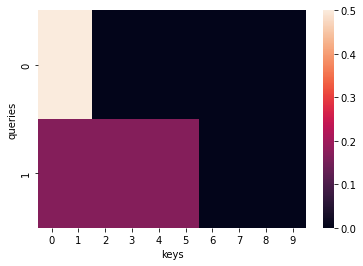

In [237]:
sns.heatmap(attention.attention_weights.squeeze(1).detach())
plt.xlabel('keys')
plt.ylabel('queries')

# 缩放点积注意力
$$a(q,k)=\frac{q^tk}{\sqrt{d}}$$
$$$softmax(\frac{QK^T}{\sqrt{d}})V$$
query和key的长度需要相同(query_size,key_size)

In [228]:
class DotProductAttention(nn.Module):
    def __init__(self,dropout,**kwargs):
        super(DotProductAttention, self).__init__()
        self.attention_weights = None
        self.dropout = nn.Dropout(dropout)
    def forward(self,queries,keys,values,valid_lens=None):
        d = torch.tensor(queries.size(-1))
        scores = torch.bmm(queries,keys.transpose(1,2))/torch.sqrt(d)
        self.attention_weights = masked_softmax(scores,valid_lens)
        return torch.bmm(self.dropout(self.attention_weights),values)

构造一个新的queries使得query_size=key_size
queries:[batch_size,1,query_size]
keys:   [batch_size,seq_len,key_size]
values: [batch_size,seq_len,vocab_size]

In [239]:
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

Text(33.0, 0.5, 'queries')

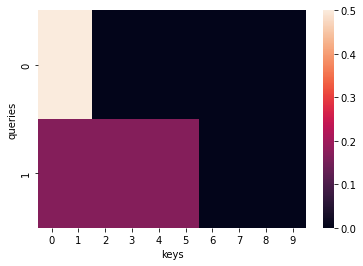

In [240]:
sns.heatmap(attention.attention_weights.squeeze(1).detach())
plt.xlabel('keys')
plt.ylabel('queries')

# 下面研究在Seq2Seq中使用注意力机制

# Bahdanau注意力

### 上下文变量c在任何解码时间步$t^{'}$都会被$c_{t^{'}}$替换 假设输入序列有T个词元,则在解码时间步$t^{'}$的上下文变量是注意力汇聚的输出:
# $c_{t^{'}} = \sum_{t=1}^T\alpha(s_{t^{'}-1},h_{t})h_{t}$
### 其中时间步$t^{'}-1$的解码器隐状态$s_{t^{'}-1}$是查询(query)
### 编码器隐状态$h_{t}$既是键(key)也是值(value)
### 其中注意力汇聚函数$\alpha$是上面定义的加性注意力打分函数

![seq2seq](https://zh-v2.d2l.ai/_images/seq2seq-attention-details.svg)

# 定义注意力解码器接口

In [242]:
class AttentionDecoder(seq2seq.Decoder):
    """带有注意力机制的通用解码器接口"""
    def __init__(self,**kwargs):
        super(AttentionDecoder, self).__init__()

    def forward(self, x, state):
        raise NotImplementedError
    @property
    def attention_weight(self):
        raise NotImplementedError

# 定义注意解码器

In [317]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self,vocab_size,embedding_dim,num_hidden,num_layers,dropout=0,**kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__()
        # 注意力层的 key_size,query_size,num_hidden 均相同
        self.attention = AdditiveAttention(num_hidden,num_hidden,num_hidden,dropout)
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.rnn = nn.GRU(embedding_dim+num_hidden,num_hidden,num_layers,dropout=dropout,batch_first=True)
        self.classify = nn.Linear(num_hidden,vocab_size)
        # 注意力权重矩阵
        self._attention_weights = None
    @classmethod
    def init_state(cls,enc_outputs,enc_valid_lens,*args):
        # 其实这里是获取encoder的输出,encoder输出两个结果:
        # 每一次rnn的预测输出&最后的隐状态ht
        # 因为我们encoder的gru设置了batch_first,这里不同再做转置
        outputs,hidden_state = enc_outputs
        return outputs,hidden_state,enc_valid_lens
    def forward(self, x, state):
        """
        :param x:       [batch_size,seq_len]
        :param state:   [num_layer,batch_size,num_hidden]
        :return:
        """
        # 从init_state中解包
        enc_outputs,hidden_state,enc_valid_lens = state
        # 词嵌入 [batch_size,seq_len,embedding_dim]
        # 转置便于计算[seq_len,batch_size,embedding_dim]
        x = self.embedding(x).permute(1,0,2)
        outputs,self._attention_weights = [],[]
        for index,xi in enumerate(x,0):
            # xi:[batch_size,embedding_dim]
            # 和之前一样,取最后一个layer用于生成上下文变量
            # [batch_size,1,num_hidden]
            query = torch.unsqueeze(hidden_state[-1],dim=1)
            # 计算注意力分数
            # [batch_size,1,num_hidden]
            context = self.attention(query,enc_outputs,enc_outputs,enc_valid_lens)
            # xi:[batch_size,1,embedding_dim]
            xi = xi.unsqueeze(1)
            # [batch_size,1,embedding_dim+num_hidden]
            xi = torch.cat((context,xi),dim=-1)
            # 因为设置了batch_first,因此不需要再变形状
            # out:[batch_size,1,embedding_dim+num_hidden]
            # hidden_state:[num_layer,batch_size,num_hidden]
            out,hidden_state = self.rnn(xi,hidden_state)
            # 将当前位置预测追加到预测结果列表
            outputs.append(out)
            # 保存对应位置的注意力
            self._attention_weights.append(self.attention.attention_weights)
        # 执行for完毕后
        # outputs:[seq_len,batch_size,embedding_dim+num_hidden]
        outputs = torch.cat(outputs,dim=1)
        # classify后
        # outputs:[seq_len,batch_size,vocab_size]
        outputs = self.classify(outputs)
        # 变回[batch_size,seq_len,]
        return outputs.permute(1,0,2),(enc_outputs,hidden_state,enc_valid_lens)
    @property
    def attention_weight(self):
        return self._attention_weights

#### 需要注意forward中outputs的序列拼接

# 构造数据,测试注意力解码器

编码器,解码器

In [318]:
encoder = seq2seq.Seq2SeqEncoder(vocab_size=10,embedding_dim=8,num_hidden=16,num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10,embedding_dim=8,num_hidden=16,num_layers=2)
decoder.eval()
pass

模拟输入
x:[batch_size,seq_len] x[0][0]表示一个单词在词汇表的索引
state:tuple(编码器个时刻输出,最后时刻ht,enc_valid_lens=None)

In [319]:
x = torch.zeros((4,7),dtype=torch.long)
state = decoder.init_state(encoder(x),None)
output,state = decoder(x,state)

对state进行解包
0:编码器各时刻的输出
1:编码器最后时刻的隐藏层状态
2:有效长度

In [324]:
state[0].shape,state[1].shape,state[2]

(torch.Size([4, 7, 16]), torch.Size([2, 4, 16]), None)